# Search Ranking Stack - Interactive Walkthrough

This notebook walks through the multi-stage search ranking pipeline on the **Amazon ESCI product search dataset**:

1. **Stage 1a**: BM25 Sparse Retrieval
2. **Stage 1b**: Dense Bi-Encoder Retrieval
3. **Stage 1c**: Hybrid RRF Fusion
4. **Stage 2**: Cross-Encoder Reranking
5. **Stage 3**: LLM Listwise Reranking (optional)

Each stage shows code, explains the approach, and evaluates performance.

## Setup

First, let's import the necessary modules and load the data.

In [1]:
# Install dependencies if needed
# !uv sync --extra notebook

In [2]:
from search_ranking_stack.data_loader import load_esci
from search_ranking_stack.evaluate import evaluate, format_metrics, analyze_label_ranking
from search_ranking_stack.stages import (
    run_bm25,
    run_dense,
    run_hybrid_rrf,
    run_cross_encoder,
    run_llm_rerank,
)

## Load Amazon ESCI Dataset

Amazon ESCI (Shopping Queries Dataset) contains:
- **~10,000 products**: Product titles, brands, and descriptions
- **500 test queries**: Real user shopping queries
- **Graded relevance labels**:
  - Exact (3): Fits all criteria
  - Substitute (2): Functional alternative
  - Complement (1): Related item
  - Irrelevant (0): Not relevant

In [3]:
data = load_esci()

print(f"Corpus: {len(data.corpus):,} products")
print(f"Queries: {len(data.queries):,} test queries")
print(f"Qrels: {sum(len(v) for v in data.qrels.values()):,} judgments")

Loading ESCI dataset...

Loading corpus...

✓ Loaded 9,870 products

Loading queries...

✓ Loaded 500 queries

Loading relevance judgments...

✓ Loaded 9,984 judgments for 500 queries

Corpus: 9,870 products
Queries: 500 test queries
Qrels: 9,984 judgments


In [4]:
# Let's look at a sample query and product
sample_qid = list(data.queries.keys())[0]
sample_query = data.queries[sample_qid]
print(f"Sample Query ({sample_qid}):")
print(f"  {sample_query}")

# Get a relevant product for this query
if sample_qid in data.qrels:
    rel_docs = data.qrels[sample_qid]
    # Find an Exact match (score 3)
    exact_pid = next(
        (pid for pid, score in rel_docs.items() if score == 3), list(rel_docs.keys())[0]
    )
    print(f"\nRelevant Product ({exact_pid}):")
    if exact_pid in data.corpus_meta:
        meta = data.corpus_meta[exact_pid]
        print(f"  Title: {meta.get('product_title')}")
        print(f"  Brand: {meta.get('product_brand')}")
    print(f"  Text: {data.corpus[exact_pid][:200]}...")

Sample Query (52460):
  i said im a mermaid not your maid

Relevant Product (B08FRP4H2Z):
  Title: When This Virus is Over Graphic Novelty Sarcastic Funny T Shirt XL Black
  Brand: Feelin Good Tees
  Text: When This Virus is Over Graphic Novelty Sarcastic Funny T Shirt XL Black Brand: Feelin Good Tees AWESOME FIT: Fits True to size, great fit and feel - Wash with cold water, inside out. Want to make dad...


---

## Stage 1a: BM25 Sparse Retrieval

**BM25 (Best Matching 25)** is a classic lexical retrieval method:
- Matches query terms with product terms
- Fast and interpretable
- Struggles with vocabulary mismatch (e.g., query 'sneakers' vs product 'running shoes')

In [5]:
bm25_results = run_bm25(data)
bm25_metrics = evaluate(data.qrels, bm25_results)
print("\n" + format_metrics(bm25_metrics))

Stage 1a: BM25 Retrieval

Indexing 9,870 documents...

done (0.3s)

Retrieving for 500 queries...

done (2.6s)


MRR@10: 0.8116 | Recall@100: 0.7407 | NDCG@10: 0.5854


---

## Stage 1b: Dense Bi-Encoder Retrieval

**Dense retrieval** uses neural embeddings:
- Encodes queries and products into dense vectors
- Captures semantic meaning beyond keyword overlap
- We use `all-MiniLM-L6-v2` (22M params)

In [6]:
dense_results = run_dense(data)
dense_metrics = evaluate(data.qrels, dense_results)
print("\n" + format_metrics(dense_metrics))

Stage 1b: Dense Bi-Encoder Retrieval (sentence-transformers/all-MiniLM-L6-v2)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading cached embeddings from corpus_embeddings.npy...

Encoding 500 queries...

done (0.4s)

Computing similarities...

done (0.01s)


MRR@10: 0.8085 | Recall@100: 0.8254 | NDCG@10: 0.6107


---

## Stage 1c: Hybrid RRF Fusion

**Reciprocal Rank Fusion (RRF)** combines BM25 and Dense rankings:
- Robust to different score scales
- Often outperforms individual methods

In [7]:
hybrid_results = run_hybrid_rrf(bm25_results, dense_results)
hybrid_metrics = evaluate(data.qrels, hybrid_results)
print("\n" + format_metrics(hybrid_metrics))

Stage 1c: Hybrid Search (RRF Fusion, k=60)

Fusing BM25 + Dense results for 500 queries...

done (0.02s)

Example — Query 58411:

Hybrid rescued 2 doc(s) into top-10 that weren't in either individual top-10


MRR@10: 0.8341 | Recall@100: 0.8421 | NDCG@10: 0.6281


---

## Stage 2: Cross-Encoder Reranking

**Cross-encoders** score query-product pairs jointly:
- More accurate but slower
- Ideal for refining top-N candidates
- We rerank top-50 from hybrid stage

In [8]:
ce_results = run_cross_encoder(data, hybrid_results)
ce_metrics = evaluate(data.qrels, ce_results)
print("\n" + format_metrics(ce_metrics))

Stage 2: Cross-Encoder Reranking (cross-encoder/ms-marco-MiniLM-L-12-v2)

Loading cross-encoder model...

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-12-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Reranking top-50 candidates per query...

  Reranking: 100%|██████████| 500/500 [10:47<00:00,  1.29s/it]


500/500 queries reranked (avg 1294ms/query)


MRR@10: 0.8605 | Recall@100: 0.8421 | NDCG@10: 0.6449


---

## Stage 3: LLM Reranking (Optional)

Uses Large Language Models to rank items listwise.
Requires manual activation via `--llm-mode` in CLI.

In [9]:
# To run LLM reranking, use the CLI:
# uv run run-all --llm-mode ollama
print("LLM reranking skipped in notebook mode. Run via CLI to enable.")

LLM reranking skipped in notebook mode. Run via CLI to enable.


---

## Comparison & Visualization

Let's compare the metrics across stages.

In [10]:
from search_ranking_stack.visualize import plot_comparison, plot_label_distribution, print_table

all_metrics = {
    "BM25": bm25_metrics,
    "Dense": dense_metrics,
    "Hybrid": hybrid_metrics,
    "+ Cross-Encoder": ce_metrics,
}

print_table(all_metrics)

           Search Ranking Stack Results            
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┓
┃ Stage           ┃ NDCG@10 ┃ MRR@10 ┃ Recall@100 ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━┩
│ BM25            │  0.5854 │ 0.8116 │     0.7407 │
│ Dense           │  0.6107 │ 0.8085 │     0.8254 │
│ Hybrid          │  0.6281 │ 0.8341 │     0.8421 │
│ + Cross-Encoder │  0.6449 │ 0.8605 │     0.8421 │
└─────────────────┴─────────┴────────┴────────────┘

✓ Chart saved to: /Users/slava/Projects/search-ranking-stack/results/metrics_comparison.png

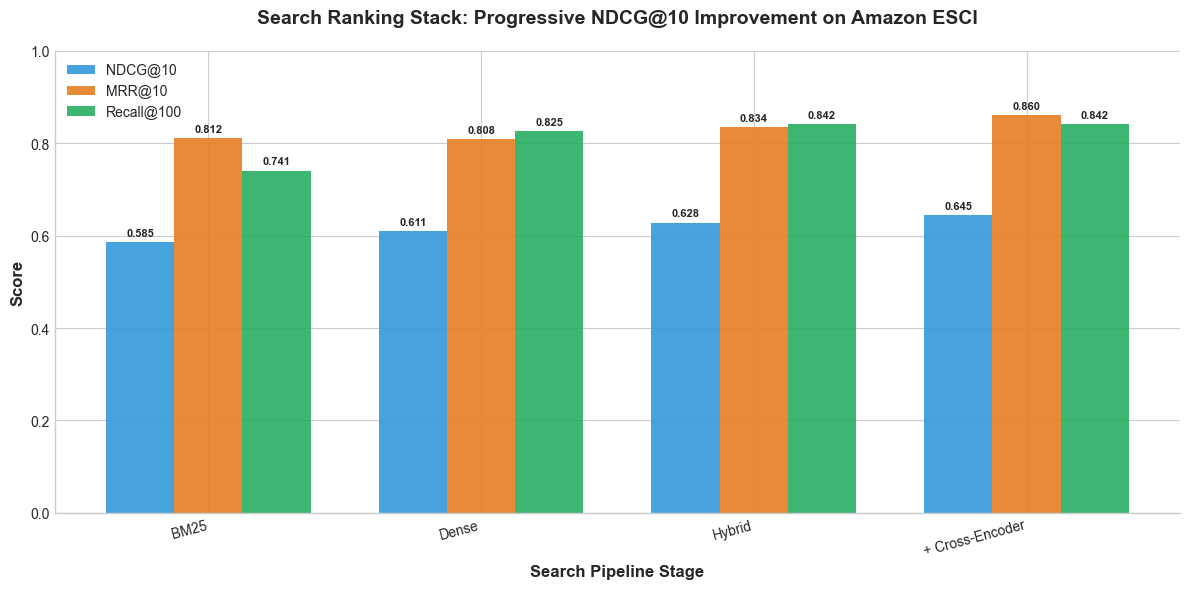

PosixPath('/Users/slava/Projects/search-ranking-stack/results/metrics_comparison.png')

In [11]:
# Plot metrics comparison
import matplotlib.pyplot as plt

plot_comparison(all_metrics, show=True)

## Label Distribution Analysis

Check how many Exact/Substitute matches are in the top-10.

✓ Label distribution chart saved to: /Users/slava/Projects/search-ranking-stack/results/label_distribution.png

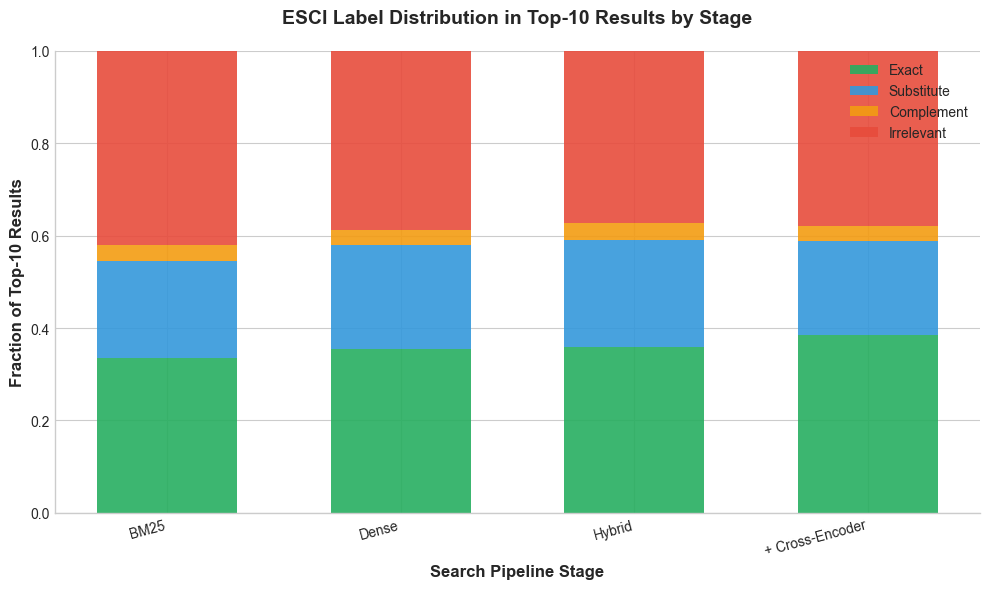

PosixPath('/Users/slava/Projects/search-ranking-stack/results/label_distribution.png')

In [12]:
all_results = {
    "BM25": bm25_results,
    "Dense": dense_results,
    "Hybrid": hybrid_results,
    "+ Cross-Encoder": ce_results,
}

label_dist = {name: analyze_label_ranking(data.qrels, res) for name, res in all_results.items()}
plot_label_distribution(label_dist, show=True)

---

## Try Your Own Query

Interact with the trained system.

In [13]:
from sentence_transformers import SentenceTransformer
import numpy as np
from search_ranking_stack.config import CORPUS_EMBEDDINGS_PATH

# Your query here
my_query = "laptop stand adjustable"

# 1. Dense retrieval
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
query_emb = model.encode([my_query], normalize_embeddings=True)
corpus_embs = np.load(CORPUS_EMBEDDINGS_PATH)

doc_ids = list(data.corpus.keys())
scores = np.dot(query_emb, corpus_embs.T)[0]
top_indices = np.argsort(scores)[::-1][:5]

print(f"Query: {my_query}\n")
print("Top 5 Results (Dense):")
for i, idx in enumerate(top_indices, 1):
    doc_id = doc_ids[idx]
    meta = data.corpus_meta.get(doc_id, {})
    title = meta.get("product_title", "Unknown")
    print(f"\n{i}. [{doc_id}] {title[:60]}... (score: {scores[idx]:.4f})")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Query: laptop stand adjustable

Top 5 Results (Dense):

1. [B07T541PXC] Laptop Stand Adjustable, Lamicall Notebook Holder : Multi-An... (score: 0.7710)

2. [B07T4G7RJY] Laptop Stand Adjustable Laptop Computer Stand Multi-Angle St... (score: 0.7589)

3. [B07HBQSCM3] Laptop Stand, Boyata Laptop Holder, Multi-Angle Stand with H... (score: 0.7205)

4. [B07D74DT3B] Soundance Laptop Stand, Aluminum Computer Riser, Ergonomic L... (score: 0.7141)

5. [B004HJ5FSW] Pyle Portable Adjustable Laptop Stand - 6.3 to 10.9 Inch Sta... (score: 0.6710)
